In [1]:
%load_ext autoreload
%autoreload 2
from utils import load_model
from argparse import Namespace

from dataset.dataset import SetKnowledgeTrendingSinusoidsDistShift
from dataset.utils import get_dataloader
from evaluation.utils import get_summary_df
from models.loss import NLL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

plt.style.use("science")
sns.set_style("whitegrid")
sns.set_palette("Dark2")
plt.rcParams["text.latex.preamble"] = (
    "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"
)

/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the models
save_dirs = {
    "NP": "../saves/INPs_sinusoids/np_dist_shift_1",
    "INP": "../saves/INPs_sinusoids/inp_b_dist_shift_1",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(
        save_dir, load_it="best"
    )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/INPs_sinusoids/np_dist_shift_1
../saves/INPs_sinusoids/inp_b_dist_shift_1


In [3]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=25,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids-dist-shift",
    device="cuda:0",
)

test_dataset = SetKnowledgeTrendingSinusoidsDistShift(
    root="../data/trending-sinusoids-dist-shift", split="test", knowledge_type="b"
)
test_data_loader = get_dataloader(test_dataset, config)

train_dataset = SetKnowledgeTrendingSinusoidsDistShift(
    root="../data/trending-sinusoids-dist-shift", split="train", knowledge_type="b"
)
train_data_loader = get_dataloader(train_dataset, config)

In [4]:
eval_type_ls = ["raw", "informed"]

train_summary_df, _, train_output_dict = get_summary_df(
    model_dict, config_dict, train_data_loader, eval_type_ls, model_names
)
test_summary_df, _, test_output_dict = get_summary_df(
    model_dict, config_dict, test_data_loader, eval_type_ls, model_names
)

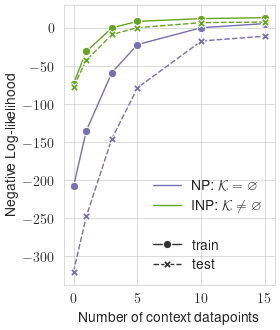

In [5]:
train_summary_df["split"] = "train"
test_summary_df["split"] = "test"

plot_df = pd.concat([train_summary_df, test_summary_df])
plot_df = plot_df[
    ((plot_df.model_name == "INP") & (plot_df.eval_type == "informed"))
    | ((plot_df.model_name == "NP") & (plot_df.eval_type == "raw"))
]

plot_df["mean"] = -plot_df["mean"]
plot_df["eval_type"] = plot_df["eval_type"].map(
    {
        "raw": r"NP: $\mathcal{K} = \varnothing$",
        "informed": r"INP: $\mathcal{K} \neq \varnothing$",
    }
)

fig, ax = plt.subplots(figsize=(3, 3.5))
sns.lineplot(
    plot_df,
    x="num_context",
    y="mean",
    hue="eval_type",
    style="split",
    palette=["C2", "C4"],
    markers=True,
)

ax.set_ylabel("Negative Log-likelihood")
ax.set_xlabel("Number of context datapoints")

handles, labels = ax.get_legend_handles_labels()

labels[0] = ""
labels[3] = ""

plt.legend(labels=labels, handles=handles)
plt.tight_layout()
# plt.savefig('../figures/exp-2.pdf', bbox_inches='tight')
plt.show()

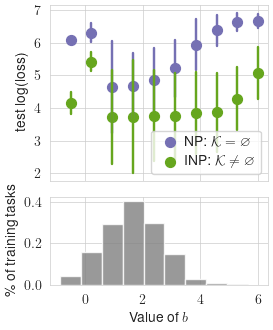

In [6]:
loss = NLL()


def get_loss_bs(output_dict, model_name="INP", eval_type="informed", num_context=0):
    bs_ls = []
    this_loss_ls = []
    for batch_idx in range(len(output_dict[model_name][eval_type][num_context])):
        outputs = output_dict[model_name][eval_type][num_context][batch_idx]["outputs"]
        y_target = output_dict[model_name][eval_type][num_context][batch_idx][
            "y_target"
        ]
        knowledge = output_dict[model_name][eval_type][num_context][batch_idx][
            "knowledge"
        ].cpu()
        bs = knowledge[:, 0, 3]

        this_loss, _, _ = loss.get_loss(
            outputs[0], outputs[1].cuda(), outputs[2], outputs[3], y_target.cuda()
        )
        this_loss = this_loss.cpu()
        this_loss_ls.append(this_loss)
        bs_ls.append(bs)

    bs = torch.cat(bs_ls)
    this_loss = torch.cat(this_loss_ls)

    return this_loss, bs


train_loss_informed, train_bs_informed = get_loss_bs(
    train_output_dict, eval_type="informed"
)
test_loss_informed, test_bs_informed = get_loss_bs(
    test_output_dict, eval_type="informed"
)
test_loss_raw, test_bs_raw = get_loss_bs(
    test_output_dict, eval_type="raw", model_name="NP"
)


bins = np.linspace(-0.5, 6, 10)

raw_df = pd.DataFrame({"b": test_bs_raw, "loss": torch.log(test_loss_raw)})
raw_df["bin"] = pd.cut(raw_df["b"], bins=bins)
raw_df["eval_type"] = "raw"
informed_df = pd.DataFrame(
    {"b": test_bs_informed, "loss": torch.log(test_loss_informed)}
)
informed_df["bin"] = pd.cut(raw_df["b"], bins=bins)
informed_df["eval_type"] = "informed"
all_df = pd.concat([raw_df, informed_df]).reset_index(drop=True)


fig, axs = plt.subplots(2, 1, figsize=(3, 3.5), sharex=True, height_ratios=[2, 1])

sns.regplot(
    data=raw_df,
    label=r"NP: $\mathcal{K} = \varnothing$",
    ax=axs[0],
    x_ci="sd",
    x="b",
    y="loss",
    x_bins=bins,
    fit_reg=False,
    color="C2",
)
sns.regplot(
    data=informed_df,
    label=r"INP: $\mathcal{K} \neq \varnothing$",
    ax=axs[0],
    x_ci="sd",
    x="b",
    y="loss",
    x_bins=bins,
    fit_reg=False,
    color="C4",
)


axs[1].hist(
    train_bs_informed, color="grey", alpha=0.8, bins=bins, density=True, align="left"
)
axs[0].legend()
axs[0].legend(
    handletextpad=0.05,
    loc="lower right",
    facecolor="white",
    framealpha=0.8,
    frameon=True,
)
axs[0].set_ylabel("test log(loss)")
axs[1].set_ylabel("\% of training tasks")
axs[0].set_xlabel("")
axs[1].set_xlabel("Value of $b$")
plt.tight_layout()
# plt.savefig('../figures/ood_details.pdf', bbox_inches='tight')
plt.show()